In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import lasio as la
import seaborn as sns
import bruges as br

%matplotlib inline

# Define a default font for the figures
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.size'] = 12
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

# Initialize Plotly and Cufflinks
from plotly import __version__
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [23]:
# Physical properties of constituents

K_o=0.82     # oil
Rho_o=0.8

K_w=2.2
G_w=0         # water
Rho_w=1.0

K_ca=71  
G_ca=30       # calcite
Rho_ca=2.71

K_q=37.3  
G_q=44.8      # quartz
Rho_q=2.65

K_k=28.1  
G_k=10.5       # kaolinite
Rho_k=2.6

K_s=28.7  
G_s=10.8       # smectite
Rho_s=2.6

# Volume fraction of large calcite and large silicates 
c_l = 0.3 # large calcite
q_l = 0.1 # large quartz
k_l = 0.05 # large kaolinite

# Volume fraction of small calcite and suspended silicates
c_s = 0.4 # small calcite
q_s = 0.05 # small quartz
k_s = 0.05 # small kaolinite
s_s = 0.05 # small smectite

print('Total volume fraction of solids equals: ', np.round(c_l+q_l+k_l+c_s+q_s+k_s+s_s,0))

# Reservoir properties
Por_c = 0.5 # Critical porosity
Por=np.linspace(0,Por_c,100)
S_w = 0.2 # water saturation
fluidMix = 'reuss'

Total volume fraction of solids equals:  1.0


In [33]:
# Modeling

K_sus = np.nan*np.ones((Por.size,11))
K_HSU = np.nan*np.ones((Por.size,11))
G_HSU = np.nan*np.ones((Por.size,11))
M_HSU = np.nan*np.ones((Por.size,11))
Vp = np.nan*np.ones((Por.size,11))
Vs = np.nan*np.ones((Por.size,11))
Rho = np.nan*np.ones((Por.size,11))

n=0;
for IF in np.arange(0,1.1,0.1):
    
    if fluidMix == 'patchy':
        K_f = S_w*K_w + (1-S_w)*K_o; # Patchy Voigt mixing the water and oil
        
        # Homogeneous Reuss mixing of fluid and suspended minerals
        K_sus[:,n] = ( (Por/Por_c)/K_f + (1-Por/Por_c)*((c_s*(1-IF)/K_ca) + (q_s/K_q) + (k_s/K_k) + (s_s/K_s)) )**(-1) * (Por/Por_c + (1-Por/Por_c)*(c_s*(1-IF) + q_s + k_s + s_s) )
        
    else:
        K_sus[:,n] = ( Por/Por_c*((S_w/K_w) + ((1-S_w)/K_o)) + (1-Por/Por_c)*((c_s*(1-IF)/K_ca) + (q_s/K_q) + (k_s/K_k) + (s_s/K_s)) )**(-1) * (Por/Por_c + (1-Por/Por_c)*(c_s*(1-IF) + q_s + k_s + s_s) )
    
    Rho[:,n] = (Por/Por_c)*((1-IF)*c_s*Rho_ca + (Rho_w*S_w) + (Rho_o*(1-S_w)) + Rho_s*s_s + Rho_k*k_s + Rho_q*q_s) + (1-(Por/Por_c))*((IF*c_s+c_l)*Rho_ca + q_l*Rho_q + k_l*Rho_k);

    K_HSU[:,n] = ( ((Por/Por_c)/(K_sus[:,n] + (4/3)*G_ca)) + (1-(Por/Por_c))* ( (((1-IF)*c_s + s_s + q_s + k_s)/(K_sus[:,n] + (4/3)*G_ca)) + ((IF*c_s+c_l)/(K_ca + (4/3)*G_ca)) + (q_l / (K_q + (4/3)*G_ca)) + (k_l / (K_k + (4/3)*G_ca)) ))**(-1) - (4/3)*G_ca

    zeta = (G_ca/6) * ((9*K_ca + 8*G_ca)/(K_ca + 2*G_ca));

    G_HSU[:,n] = ( ((Por/Por_c)/zeta) +  (1-(Por/Por_c))*( (((1-IF)*c_s + s_s + q_s + k_s)/(zeta)) + ((IF*c_s+c_l)/(G_ca + zeta)) + (q_l/(G_q + zeta)) + (k_l / (G_k + zeta))) )**(-1) - zeta;
    
    M_HSU[:,n] = K_HSU[:,n] + (4/3)*G_HSU[:,n]
    
    Vp[:,n] = np.sqrt(K_HSU[:,n] + (4/3)*G_HSU[:,n] / Rho[:,n])
    Vs[:,n] = np.sqrt(G_HSU[:,n] / Rho[:,n])
    
    n=n+1
    



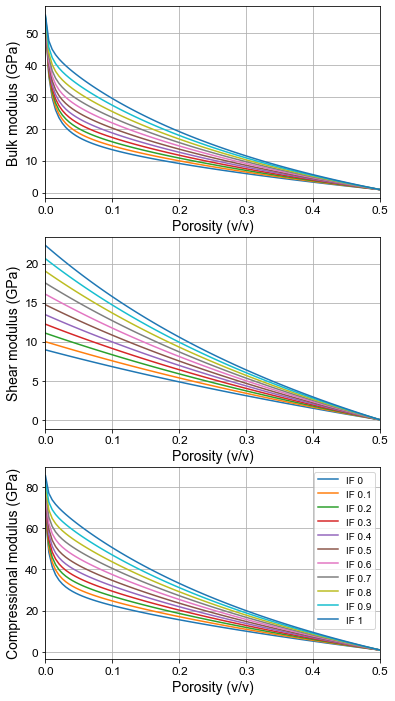

In [36]:
#   Create the plot figure
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(6, 12))
fig.set_facecolor('white')

#   Plot log curves in two-way time
ax[0].plot(Por,K_HSU)
ax[0].set_xlim(0, Por_c)
ax[0].set_ylabel('Bulk modulus (GPa)', fontsize = 14)
ax[0].set_xlabel('Porosity (v/v)', fontsize = 14)
ax[0].grid()

ax[1].plot(Por,G_HSU)
ax[1].set_xlim(0, Por_c)
ax[1].set_ylabel('Shear modulus (GPa)', fontsize = 14)
ax[1].set_xlabel('Porosity (v/v)', fontsize = 14)
ax[1].grid()

ax[2].plot(Por,M_HSU)
ax[2].set_xlim(0, Por_c)
ax[2].set_ylabel('Compressional modulus (GPa)', fontsize = 14)
ax[2].set_xlabel('Porosity (v/v)', fontsize = 14)
ax[2].grid()

plt.legend(['IF 0','IF 0.1','IF 0.2','IF 0.3','IF 0.4','IF 0.5','IF 0.6','IF 0.7','IF 0.8','IF 0.9','IF 1'])
plt.show()

